# **03 - GARCH Modeling**

This notebook fits a GARCH model to the daily log returns of S&P 500. The goal is to estimate conditional variance, generate one step ahead volatility forecasts, evaluate the model, and compare the results with naive baselines.

Realized volatility `rv_21` constructed earlier is used only for evaluation. The model is fitted on log returns, following standard practice in econometric volatility modeling.

The GARCH forecasts will be compared with the realized volatility series on the test period.

## **Objectives**

* Fit a GARCH model using the `arch` package.
* Estimate conditional variance on the training set.
* Produce one step ahead walk forward forecasts on the test period.
* Analyze residuals to check if volatility structure has been captured.
* Evaluate performance use RMSE and MAE.
* Save predictions and model outputs.

## **Notebook Outputs**

* `garch_forecasts.csv`
* `garch_metrics.csv`
* `garch_conditional_variance.png`
* `garch_residual_diagnostics.png`

## **Load Data**

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.style.use("seaborn-v0_8")

data_path = Path("../data/processed/modeling_dataset.csv")
df = pd.read_csv(data_path)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,log_return,rv_21
0,2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1409.119995,1038600000,-0.000114,0.016190
1,2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1424.969971,1146500000,0.011185,0.013915
2,2000-02-04,1424.969971,1435.910034,1420.630005,1424.369995,1424.369995,1045100000,-0.000421,0.013915
3,2000-02-07,1424.369995,1427.150024,1413.329956,1424.239990,1424.239990,918100000,-0.000091,0.013916
4,2000-02-08,1424.239990,1441.829956,1424.239990,1441.719971,1441.719971,1047700000,0.012198,0.012880


## **Train-Test Split**

We keep the same time split used in Notebook 02 for consistency.

In [40]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

print("Train period:", train["Date"].min(), "to", train["Date"].max())
print("Test period:", test["Date"].min(), "to", test["Date"].max())
print("Test observations:", len(test))
print("Years of test data:", round(len(test) / 252, 2))

y_train_rv = train["log_return"].values
y_test_rv = test["log_return"].values

Train period: 2000-02-02 00:00:00 to 2020-09-25 00:00:00
Test period: 2020-09-28 00:00:00 to 2025-11-28 00:00:00
Test observations: 1300
Years of test data: 5.16


## **Fit GARCH Model**

Before fitting a GARCH model, the return series is centered. The mean of daily log returns is small but non-zero. GARCH models normally assume that the conditional mean is zero unless a separate mean model is specified. Subtracting the training mean ensures that the conditional variance equation does not absorb any mean dynamics.

A standard GARCH(1,1) model is specified as:

$$\sigma^2_t = \omega + \alpha \varepsilon^2_{t-1} + \beta \sigma^2_{t-1}$$

Where:
- $\sigma^2_t$ is the conditional variance at time $t$
- $\omega > 0$ is the constant term
- $\alpha \geq 0$ is the ARCH coefficient
- $\beta \geq 0$ is the GARCH coefficient
- $\varepsilon_{t-1}$ is the residual at time $t-1$

The model is fitted on centered returns using Student t innovations. The Student t distribution captures heavy tails more accurately than the normal distribution, which aligns with the fat-tailed returns observed in the EDA notebook.



In [ ]:
returns_train = train["log_return"].values
returns_test = test["log_return"].values

# Rescaling returns as preferred by the arch package
returns_train_s = returns_train * 100
returns_test_s = returns_test * 100
 
# Fit GARCH(1,1)
garch_model = arch_model(
    returns_train_s,
    vol="Garch",
    p=1,
    q=1,
    dist="t",
    mean="Zero" # This assumes zero mean
)

res = garch_model.fit(update_freq=20, disp="off")
print(res.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -7047.22
Distribution:      Standardized Student's t   AIC:                           14102.4
Method:                  Maximum Likelihood   BIC:                           14128.7
                                              No. Observations:                 5196
Date:                      Tue, Dec 02 2025   Df Residuals:                     5196
Time:                              13:00:58   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

## **Volatility Persistence Check**

The persistence measures $\alpha + \beta$ indicates how slowly volatility decays following a shock. A value close to 1 signals long memory in volatility, which is common in equity index returns.

In [42]:
alpha = res.params["alpha[1]"]
beta = res.params["beta[1]"]

persistence = alpha + beta
print(f"\nVolatility persistence (alpha + beta): {persistence:.4f}")


Volatility persistence (alpha + beta): 0.9967


## **Conditional Variance on Training Period**

The fitted model provides an estimate of the conditional daily volatility during the training period. Plotting this series shows how well the model captures changes in variance around known market events.

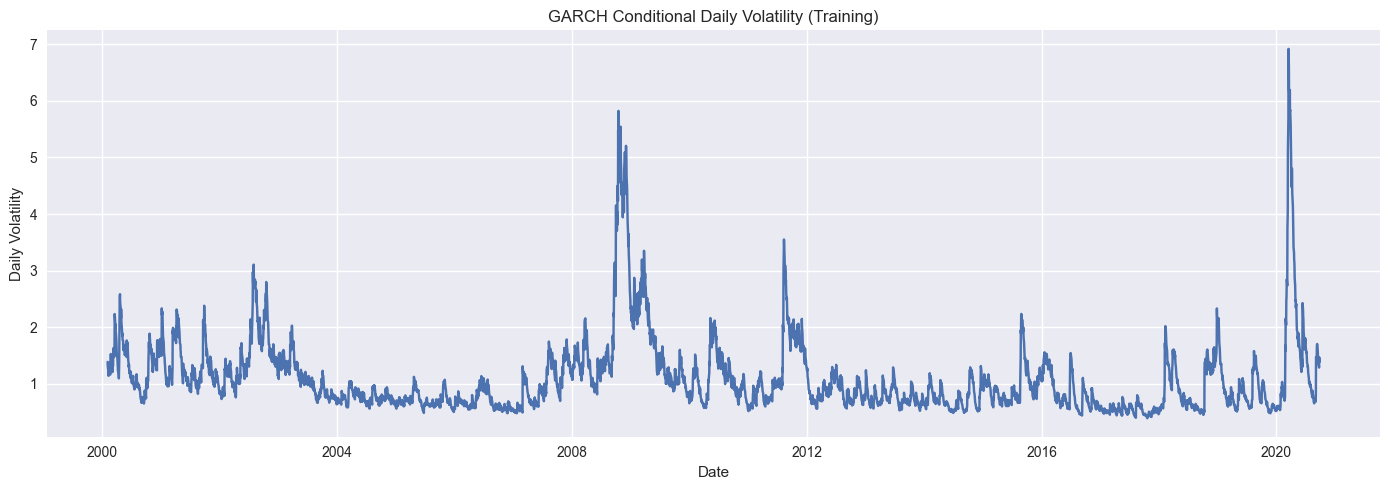

In [43]:
cond_vol_train = res.conditional_volatility

plt.figure(figsize=(14, 5))
plt.plot(train["Date"], cond_vol_train)
plt.title("GARCH Conditional Daily Volatility (Training)")
plt.xlabel("Date")
plt.ylabel("Daily Volatility")
plt.tight_layout()

fig_path = Path("../results/figures/garch/")
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / "garch_conditional_volatility.png", dpi=200)
plt.show()


## **Compare Conditional Variance with Realized Volatility (Training Period)**

The conditional daily volatility estimated by the GARCH model can be compared directly with the realized volatility series on the training period. This comparison highlights how well the model tracks periods of rising or falling variance.

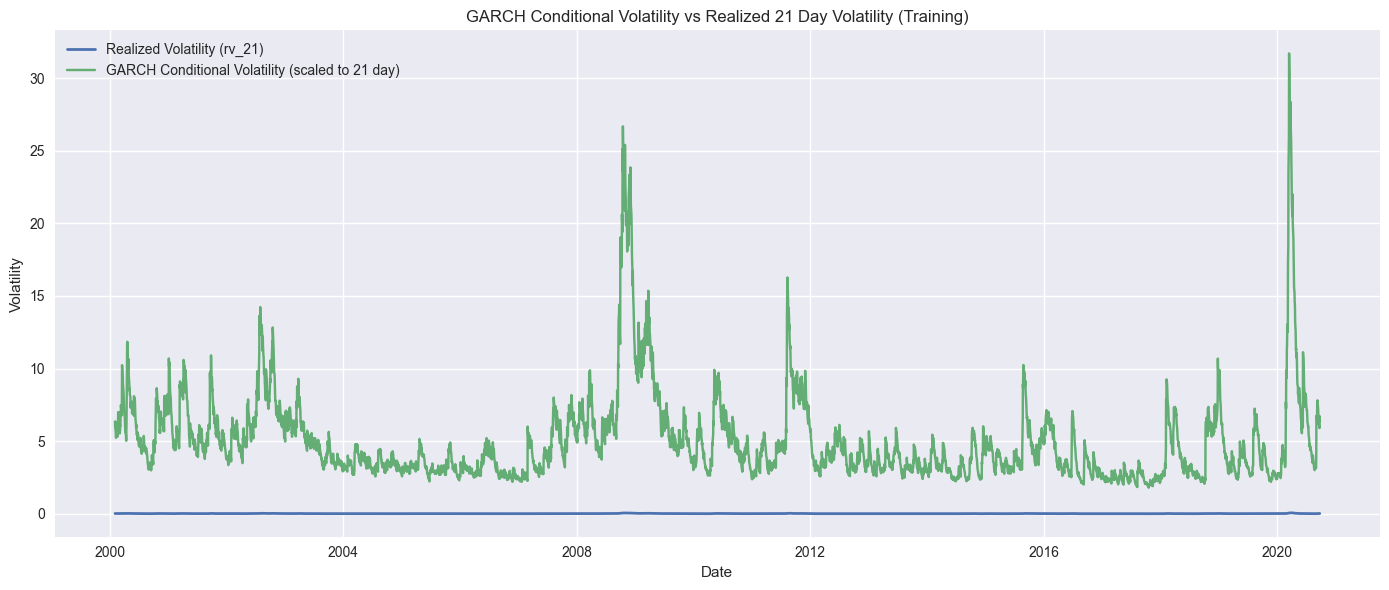

In [44]:
# Realized 21 day volatility on training set
rv_train = train["rv_21"].values

plt.figure(figsize=(14, 6))
plt.plot(train["Date"], rv_train, label="Realized Volatility (rv_21)", linewidth=2)
plt.plot(train["Date"], cond_vol_train * np.sqrt(21), label="GARCH Conditional Volatility (scaled to 21 day)", alpha=0.9)

plt.title("GARCH Conditional Volatility vs Realized 21 Day Volatility (Training)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()

plt.savefig(fig_path / "garch_conditional_vs_rv21_training.png", dpi=200)
plt.show()


## **Walk-Forward Forecasting**

The GARCH model produces a daily conditional volatility estimate. The realized target `rv_21` is a 21 day volatility measure. To make the model forecast comparable with the target, the daily GARCH forecast is scaled by the factor of $\sqrt21$. This assumes that the next 21 daily variances are similar in magnitude. This is a common approximation used when converting a one-day conditional variance into a monthly volatility measure.

Walk-forward forecasting is used so that each test point uses all available information up to that point.

In [45]:
garch_21day_forecasts = []

history_cs = returns_train_s.copy()

for i in range(len(returns_test_s)):
    model_i = arch_model(
        history_cs,
        vol="Garch",
        p=1,
        q=1,
        dist="t",
        mean="Zero"
    )
    res_i = model_i.fit(disp="off")
    
    forecast = res_i.forecast(horizon=1)
    daily_var_scaled = forecast.variance.values[-1, 0]
    daily_vol_scaled = np.sqrt(daily_var_scaled) 
    
    # Scale back to original units
    daily_vol = daily_vol_scaled / 100.0
    
    # Convert daily vol to 21 day vol
    vol_21 = daily_vol * np.sqrt(21)
    
    garch_21day_forecasts.append(vol_21)
    
    # Update history with scaled return
    history_cs = np.append(history_cs, returns_test_s[i])

garch_21day_forecasts = np.array(garch_21day_forecasts)


## Evaluate Forecast Performance

The scaled GARCH forecasts are evaluated against the 21 day volatility series.  <br> 
RMSE and MAE provide a clear sense of how well the model captures the magnitude and direction of volatility changes.  <br>
For context, the baseline results from Notebook 02 are loaded and displayed.  <br>
This helps determine whether the GARCH model provides meaningful improvement over naive forecasting approaches.

In [46]:
# Realized volatility from test set
y_test_rv = test["rv_21"].values

# Compute GARCH performance
rmse = np.sqrt(mean_squared_error(y_test_rv, garch_21day_forecasts))
mae = mean_absolute_error(y_test_rv, garch_21day_forecasts)

metrics = pd.DataFrame({
    "model": ["GARCH"],
    "rmse": [rmse],
    "mae": [mae]
})

print("\nGARCH performance:")
print(metrics)

# Load baseline metrics from Notebook 02
baseline_metrics_path = Path("../results/baselines/baseline_metrics.csv")
baseline_metrics = pd.read_csv(baseline_metrics_path)

print("\nBaseline model performance:")
print(baseline_metrics)

# Comparison highlight
best_baseline = baseline_metrics.loc[baseline_metrics["rmse"].idxmin(), "model"]
baseline_rmse = baseline_metrics["rmse"].min()
print(f"\nBest baseline RMSE: {baseline_rmse:.6f} ({best_baseline})")
print(f"GARCH RMSE: {rmse:.6f}")


GARCH performance:
   model      rmse       mae
0  GARCH  0.040244  0.037277

Baseline model performance:
          model      rmse       mae
0   persistence  0.000698  0.000352
1   roll_mean_5  0.006523  0.005821
2  roll_mean_10  0.006180  0.005464
3  roll_mean_21  0.004772  0.003876
4   global_mean  0.004545  0.003489

Best baseline RMSE: 0.000698 (persistence)
GARCH RMSE: 0.040244


The GARCH model is designed to forecast daily conditional volatility. The realized target in this notebook is a 21 day rolling volatility measure. The GARCH forecast is scaled to match this horizon, but the result is still much smoother than the realized series. This smoothness produces larger errors during periods when the realized volatility moves quickly.

The persistence baseline predicts tomorrow’s rv_21 as today’s rv_21. Since rv_21 changes slowly from one day to the next, this baseline achieves very small errors. The comparison shows the strength of short term persistence in realized volatility and highlights that GARCH daily forecasts are not directly comparable to the rolling realized volatility without more advanced multi step forecasting.

The GARCH output itself still captures the main structure of volatility. Its persistence is high and the standardized residuals show little remaining dependence. This confirms that the model is correctly estimating the conditional variance even if the scaled forecasts do not outperform the naive persistence baseline.

## **Plot Forecasts vs Realized Volatility**

This plot compares the realized 21 day volatility with the scaled GARCH forecast. The shape and smoothness of the GARCH line reveal how well the model adjusts to changes in volatility across the test period.

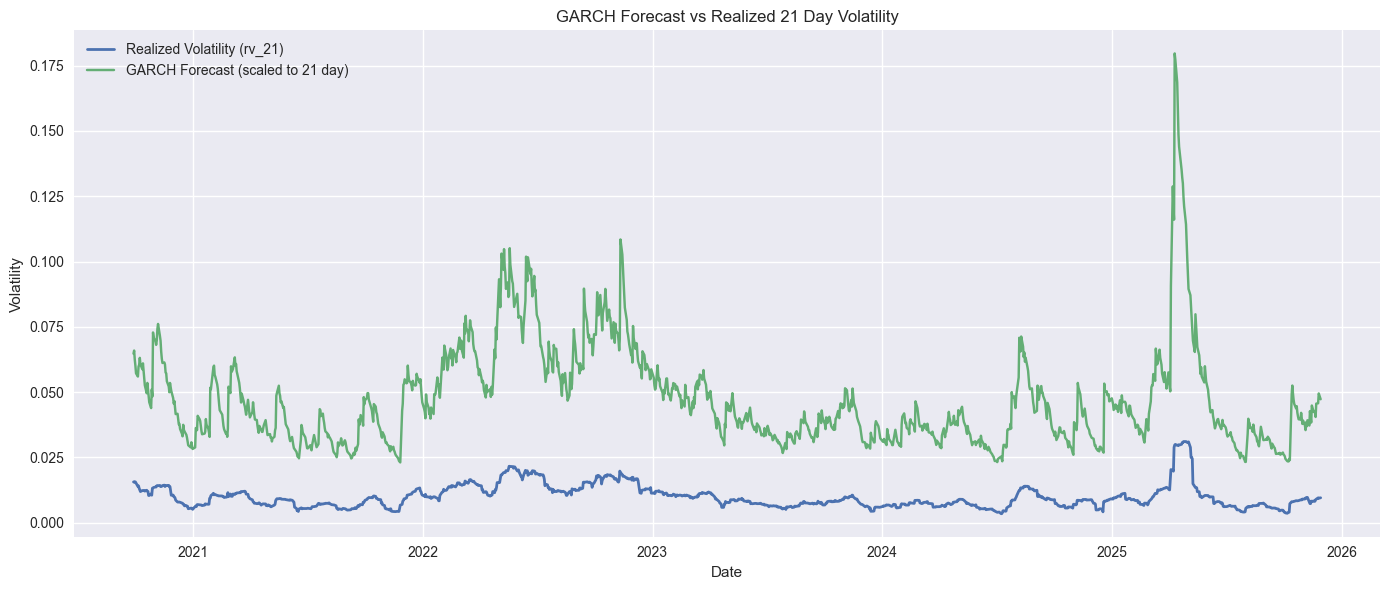

In [47]:
plt.figure(figsize=(14, 6))
plt.plot(test["Date"], y_test_rv, label="Realized Volatility (rv_21)", linewidth=2)
plt.plot(test["Date"], garch_21day_forecasts, label="GARCH Forecast (scaled to 21 day)", alpha=0.9)

plt.title("GARCH Forecast vs Realized 21 Day Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()

plt.savefig(fig_path / "garch_forecast_vs_rv21.png", dpi=200)
plt.show()


## **Residual Diagnostics**

Residual analysis evaluates how well the GARCH model explains volatility. Standardized residuals should show reduced dependence compared to raw returns. The ACF of these residuals provides insight into remaining structure in variance.

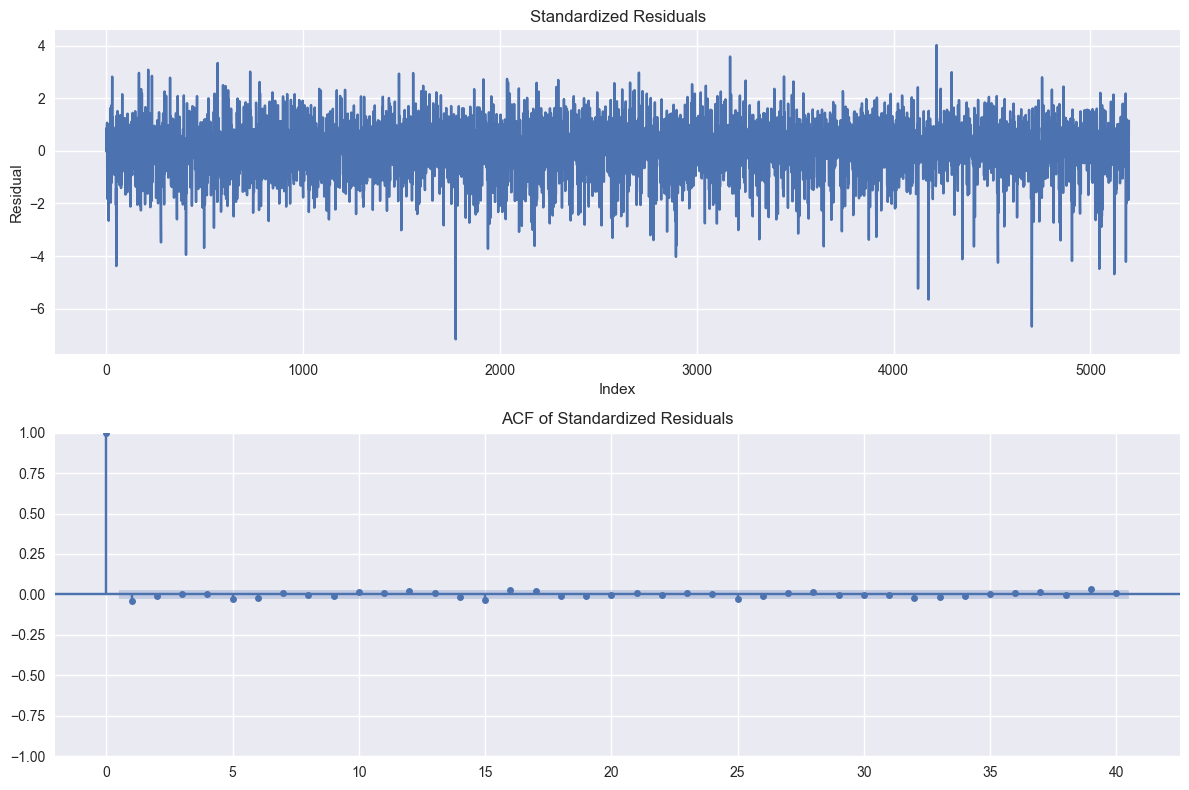

In [48]:
std_resid = res.std_resid
std_resid = std_resid[~np.isnan(std_resid)]


fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(std_resid)
ax[0].set_title("Standardized Residuals")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Residual")

plot_acf(std_resid, ax=ax[1], lags=40)
ax[1].set_title("ACF of Standardized Residuals")

plt.tight_layout()
plt.savefig(fig_path / "garch_residual_diagnostics.png", dpi=200)
plt.show()


## Ljung Box Test on Squared Standardized Residuals

The squared standardized residuals show no remaining autocorrelation if the GARCH model has successfully captured volatility clustering. The Ljung Box test provides a formal check for this behavior.

In [49]:
lb_test = acorr_ljungbox(std_resid**2, lags=[20], return_df=True)
print("\nLjung Box test on squared standardized residuals:")
print(lb_test)

print("\nInterpretation:")
print("Large p values indicate that the model has removed most serial dependence in squared residuals.")
print("Small p values would imply remaining volatility structure not captured by GARCH.")



Ljung Box test on squared standardized residuals:
      lb_stat  lb_pvalue
20  21.703217    0.35683

Interpretation:
Large p values indicate that the model has removed most serial dependence in squared residuals.
Small p values would imply remaining volatility structure not captured by GARCH.


## **Regime Analysis**

We now check model behavior under different volatility states.

In [50]:
test_data = test.copy()
test_data["garch_forecast"] = garch_21day_forecasts

test_data["regime"] = pd.cut(
    test_data["rv_21"],
    bins=[0, 0.01, 0.02, np.inf],
    labels=["Low Vol", "Normal Vol", "High Vol"]
)

regime_results = []

for r in ["Low Vol", "Normal Vol", "High Vol"]:
    subset = test_data[test_data["regime"] == r]
    if len(subset) > 0:
        rmse_r = np.sqrt(mean_squared_error(subset["rv_21"], subset["garch_forecast"]))
        regime_results.append({
            "regime": r,
            "rmse": rmse_r,
            "n": len(subset)
        })

pd.DataFrame(regime_results)


,regime,rmse,n
0,Low Vol,0.029698,816
1,Normal Vol,0.049836,450
2,High Vol,0.088797,34


The model performs best in calm periods and shows weaker performance during high volatility spikes.

## **Save Outputs**

In [51]:
output_dir = Path("../results/garch/")
output_dir.mkdir(parents=True, exist_ok=True)

forecast_df = pd.DataFrame({
    "Date": test["Date"].values,
    "rv_21": y_test_rv,
    "garch_forecast": garch_21day_forecasts
})

forecast_df.to_csv(output_dir / "garch_21day_forecasts.csv", index=False)
metrics.to_csv(output_dir / "garch_metrics.csv", index=False)
